# Grad Cafe Data Analysis

## Author

- Linghao Zhang (linghao)
- Yao Xiao (yxiao2)

## Introduction

[Grad Cafe](https://thegradcafe.com/) is an active graduate school discussion forum used mostly by applicants of university in North America. Over the years it has accumulated a large amount of data that could be valuable to graduate school applicants. In this project, we will go through the complete process of web scraping, data parsing & cleaning, exploratory data analysis and predictive modeling.

In particular, we hope to gain insights about Computer Science programs.

In [1]:
import re
import time
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
from IPython.display import Image

In [2]:
DATA_PATH = 'data'

## Scraping

In this section, we will use `requests` to crawl the data from Grad Cafe.

Admission results can be queried at [https://thegradcafe.com/survey/index.php](https://thegradcafe.com/survey/index.php). Grad Cafe doesn't support browsing through the whole database. Instead, at least one keyword must be used to retrieve the results. Since we are interested in CS programs, we will use the keyword `Computer` which returns 192 pages of results with 250 results per page.

Grad Cafe organizes the results in a `table`, which is not very difficult to parse. Therefore, we can simply retrieve the HTML source codes and save them to files for later parsing.

Note that Grad Cafe forbids requets without a proper `User-agent` header. Apart from that there seems to be no anti-crawler mechanisms.

In [3]:
for pid in range(1, 193):
    url = 'https://thegradcafe.com/survey/index.php?q=computer&t=a&pp=250&o=&p={0}'.format(pid)
    resp = requests.get(url, headers={'User-agent': 'Mozilla/5.0'})
    if resp.status_code != 200:
        print('Failed at', pid)
        break
    with open('{0}/{1}.html'.format(DATA_PATH, pid), 'w') as f:
        f.write(resp.text)
    time.sleep(1)

## Parsing

In this section, we will parse the HTML files using `BeautifulSoup` and regular expressions. The goal is to convert them into a Pandas DataFrame.

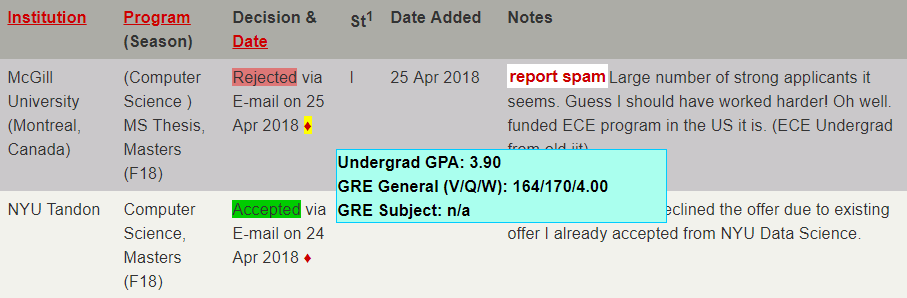

In [4]:
Image('gradcafe.PNG')

The image above shows what is contained in an admission result. From this we can derive what columns will our DataFrame contain:

- `university`: name of the university.
- `major`: name of the major.
- `degree`: can be one of `PhD`, `Masters`, `MFA`, `MBA`, `JD`, `EdD`, `Other`.
- `season`: season of admission, F/S (Fall/Spring) + year.
- `decision`: admission decision, can be one of `Accepted`, `Rejected`, `Interview`, `Wait listed`, `Other`.
- `decision_method`: method of decision notification, can be one of `Postal Service`, `E-mail`, `Phone`, `Website`, `Other`.
- `decision_date`: date of decision notification.
- `gpa`: undergraduate GPA.
- `gre_verbal`: GRE verbal score.
- `gre_quant`: GRE quantitative score.
- `gre_writing`: GRE analytical writing score.
- `status`: indicates American/international student status.
- `created_at`: date that this result was added.
- `comment`: any notes the user has made.

Note that we will not extract GRE subject score, as CS programs generally do not require a GRE subject score.

In [5]:
column_names = [
    'university',
    'major',
    'degree',
    'season',
    'decision',
    'decision_method',
    'decision_date',
    'gpa',
    'gre_verbal',
    'gre_quant',
    'gre_writing',
    'status',
    'created_at',
    'comment'
]

Some fields are in text format and we need to define several regular expressions to parse them.

In [6]:
pat_decision_info = re.compile((
'((?:Accepted)|(?:Rejected)|(?:Interview)|(?:Wait listed)|(?:Other)) via '
'((?:Postal Service)|(?:E-mail)|(?:Phone)|(?:Website)|(?:Other))'
))
pat_degree = re.compile('((?:PhD)|(?:Masters)|(?:MFA)|(?:MBA)|(?:JD)|(?:EdD)|(?:Other))')
pat_season = re.compile('(\([SF][01][0-9]\))')
pat_gpa = re.compile('GPA: ((?:[0-9]\.[0-9]{1,2})|(?:n/a))')
pat_gre = re.compile('GRE General \(V/Q/W\): ([0-9]{2,3})/([0-9]{2,3})/([0-9]\.[0-9]{1,2})')

Next, let's write a function that will parse one row (one result) from the results table. This is a regualr expression heavy process and involves a lot of details. Please refer to the comments in the code.

In [7]:
def parse_row(row):
    cols = row.findAll('td')
    
    university = cols[0].text
    
    # '(Computer Science ) MS Thesis, Masters (F18)'
    program_season_info = cols[1].text
    pos = program_season_info.rfind(',')
    # '(Computer Science ) MS Thesis'
    major = program_season_info[:pos].strip()
    # 'Masters (F18)'
    degree_season_info = program_season_info[pos+1:].strip()
    ret_degree = pat_degree.search(degree_season_info)
    # 'Masters'
    degree = ret_degree.groups()[0] if ret_degree else None
    ret_season = pat_season.search(degree_season_info)
    # 'F18'
    season = ret_season.groups()[0][1:-1] if ret_season else None
    
    # 'Rejected via E-mail on 25 Apr 2018 ...'
    decision_info = cols[2].text
    # GPA and GRE scores are inside the child elements, which will also be captured by `.text` attribute
    # Need to slice that out
    pos = cols[2].text.find('Undergrad')
    if pos != -1:
        decision_info = decision_info[:pos]
    ret_decision_info = pat_decision_info.search(decision_info)
    # ('Rejected', 'E-Mail')
    decision, decision_method = ret_decision_info.groups() if ret_decision_info else (None, None)
    pos = decision_info.rfind('on')
    # '25 Apr 2018'
    decision_date = decision_info[pos+2:].strip()
    if not decision_date: decision_date = None
    
    score_info_tag = cols[2].find(class_='extinfo')
    if score_info_tag:
        # 'Undergrad GPA: 3.90 GRE General (V/Q/W): 164/170/4.00 ...'
        score_info = score_info_tag.text
        ret_gpa = pat_gpa.search(score_info)
        # '3.90'
        gpa = ret_gpa.groups()[0] if ret_gpa else None
        if gpa == 'n/a': gpa = None
        ret_gre = pat_gre.search(score_info)
        # ('164', '170', '4.00')
        gre_verbal, gre_quant, gre_writing = ret_gre.groups() if ret_gre else (None, None, None)
    else:
        gpa, gre_verbal, gre_quant, gre_writing = None, None, None, None
    
    # 'I'
    status = cols[3].text.strip()
    if not status: status = None
    
    # '25 Apr 2018'
    created_at = cols[4].text.strip()
    if not created_at: created_at = None
    
    # 'Large number of strong applicants it seems. ...'
    comment = cols[5].text.strip()
    if not comment: comment = None
    
    return [university, major, degree, season, decision, decision_method, decision_date, gpa, gre_verbal, gre_quant, gre_writing, status, created_at, comment]

Now let's write a function that finds all the rows from a HTML file and calls `parse_row` to obtain all the parsed data from it.

In [8]:
def parse_file(filename):
    with open(filename) as f:
        html = f.read()
    soup = BeautifulSoup(html, 'html.parser')
    table = soup.find('table', class_='results')
    # Skip the header
    rows = table.findAll('tr')[1:]
    results = []
    for idx, row in enumerate(rows):
        results.append(parse_row(row))
    return results

Now we're ready to parse all the HTML files we obtained by web scraping.

In [9]:
data = []
for pid in range(1, 193):
    filename = '{0}/{1}.html'.format(DATA_PATH, pid)
    data.extend(parse_file(filename))

Finally, we are able to create a Pandas DataFrame with the parsed data, which has in total 47745 rows. A quicks look into the DataFrame shows that the results is pretty desirable.

In [10]:
df = pd.DataFrame(data)
df.columns = column_names
print(len(df))
df.head(5)

47745


,university,major,degree,season,decision,decision_method,decision_date,gpa,gre_verbal,gre_quant,gre_writing,status,created_at,comment
0,Carnege Mellon University,( ECE ) Electrical And Computer Engineering,Masters,F18,Other,Other,5 May 2018,None,None,None,None,I,5 May 2018,Is anyone yet to hear back from CMU? Is there ...
1,"(University Of California, Los Angeles (UCLA)",(Computer Science ),Masters,F18,Accepted,Website,5 May 2018,9.19,167,168,5.50,I,5 May 2018,Found the decision letter because I happened t...
2,The University Of Waterloo,(Computer Science ) MMath - Thesis,Masters,F18,Other,Other,5 May 2018,None,None,None,None,I,5 May 2018,I am still waiting for the result.
3,University Of Waterloo (Canada),(Computer Science ) MMath,Masters,F18,Other,Other,5 May 2018,None,159,170,4.50,I,5 May 2018,"Anyone still waiting for the results? For me, ..."
4,University Of Waterloo,(Computer Science ) MMath Coursework,Other,F18,Other,Other,5 May 2018,None,None,None,None,I,5 May 2018,to the poster below who accepted waterloo's of...


## Cleaning

IN this section, we will perform data cleaning on the DataFrame we just created.

Because Grad Cafe's result submission form does not perform strict checks on user input (not to mention that some human errors are not obviously detectable), it is vital that we clean up the data for later analysis and modeling.

First, let's examine which columns contain missing values and decide what to do about them.

In [11]:
def count_missing_values(df):
    for col in df.columns:
        print('Column {0} has {1} missing values'.format(col, df[col].isnull().sum()))
        
count_missing_values(df)

Column university has 0 missing values
Column major has 0 missing values
Column degree has 63 missing values
Column season has 5475 missing values
Column decision has 173 missing values
Column decision_method has 173 missing values
Column decision_date has 20 missing values
Column gpa has 34147 missing values
Column gre_verbal has 31851 missing values
Column gre_quant has 31851 missing values
Column gre_writing has 31851 missing values
Column status has 1279 missing values
Column created_at has 0 missing values
Column comment has 14011 missing values


We see that nearly three quarters of the results are missing GPA or GRE scores, which is not that surprising because people are generally reluctant to share such sensitive information.

Since our analysis will heavily depend on GPA and GRE scores, we have no alternative but to drop rows with missing values. Fortunately, that still leaves us more than 10k results to play with.

In [12]:
def drop_missing_rows(df, cols):
    n = len(df)
    for col in cols:
        df = df[~df[col].isnull()]
    print('# rows dropped: {0}/{1}'.format(n-len(df), n))
    return df

df = drop_missing_rows(df, ['degree', 'season', 'decision', 'gpa', 'gre_verbal', 'gre_quant', 'gre_writing', 'status'])

# rows dropped: 34405/47745


Before we move on, let's exmaine the data types of each column.

In [13]:
df.dtypes

university         object
major              object
degree             object
season             object
decision           object
decision_method    object
decision_date      object
gpa                object
gre_verbal         object
gre_quant          object
gre_writing        object
status             object
created_at         object
comment            object
dtype: object

Obivously, some of the columns need to be converted to numerical types.

In [14]:
def convert_numerical_values(df, cols):
    for col in cols:
        df[col] = pd.to_numeric(df[col])
    return df

df = convert_numerical_values(df, ['gpa', 'gre_verbal', 'gre_quant', 'gre_writing'])

Now we can begin to perform task-specific cleaning.

One thing we need to understand about Grad Cafe is, people don't always submit their actual admission results. Sometimes they only use it as a means to make a post, sharing or asking for information related to admission. In that case the `decision` field is often filled out as `Other`.

Also, a `Interview` / `Wait listed` decision is only an intermediate one which can lead to `Accepted` or `Rejected`. Since the results are anonymized, there is no way to figure out the final decision.

We can see from below that decisions other than `Accepted` or `Rejected` only substitute a minority of all the results. It is therefore acceptable to just filter out those results.

In [15]:
df.decision.value_counts()

Accepted       6967
Rejected       5283
Other           507
Interview       437
Wait listed     146
Name: decision, dtype: int64

In [16]:
df = df[(df.decision == 'Accepted') | (df.decision == 'Rejected')]

Similarly, we can filter out results with a `degree` field other than `Master` or `PhD`.

In [17]:
df.degree.value_counts()

Masters    6763
PhD        5455
Other        27
MBA           3
EdD           1
MFA           1
Name: degree, dtype: int64

In [18]:
df = df[(df.degree == 'Masters') | (df.degree == 'PhD')]

Now let's start examining the quantitative fields.

In [19]:
df.gpa.describe()

count    12218.000000
mean         3.775908
std          0.865537
min          0.900000
25%          3.500000
50%          3.700000
75%          3.890000
max          9.990000
Name: gpa, dtype: float64

We notice from above that there are GPAs as igh as 9.99. This is because different schools use different scales for GPA. While most schools have a maximum GPA of 4 or 4.3, there is a minority of schools that grade on a 0-10 scale. Let's see how many there are.

In [20]:
len(df[df.gpa > 4.3])

326

While it's possible to rescale 0-10 down to 0-4, it's simpler to just discard those rows because they only represent less than 3% of all the data.

In [21]:
df = df[df.gpa <= 4.3]

Now let's examine GRE scores.

In [22]:
df.gre_verbal.describe()

count    11892.000000
mean       232.838126
std        174.140163
min         55.000000
25%        154.000000
50%        160.000000
75%        167.000000
max        800.000000
Name: gre_verbal, dtype: float64

In [23]:
df.gre_quant.describe()

count    11892.000000
mean       266.545745
std        227.145951
min         50.000000
25%        163.000000
50%        167.000000
75%        170.000000
max        900.000000
Name: gre_quant, dtype: float64

Obviously we need to deal with the mix of old and new GRE scores. The old GRE score ranges from 200 to 800, with 10 as the minimum interval. While the new GRE score ranges from 170 to 130, whth 1 as the minimum interval. We can convert old scores to new scores using the [concordance table provided by ETS](https://www.ets.org/s/gre/pdf/concordance_information.pdf).

But first we need to filter out outliers.

In [24]:
len(df[(df.gre_verbal < 130) | (df.gre_verbal > 800) | (df.gre_verbal > 170) & (df.gre_verbal < 200)])

20

In [25]:
len(df[(df.gre_quant < 130) | (df.gre_quant > 800) | (df.gre_quant > 170) & (df.gre_quant < 200)])

18

In [26]:
df = df[(df.gre_verbal >= 130) & (df.gre_verbal <= 170) | (df.gre_verbal >= 200) & (df.gre_verbal <= 800)]
df = df[(df.gre_quant >= 130) & (df.gre_quant <= 170) | (df.gre_quant >= 200) & (df.gre_quant <= 800)]

The following code uses cutoff points of score conversion tables to normalize the GRE verbal/quantitative scores.

In [27]:
verbal_cutoffs = [
    200, 240, 250, 260, 270, 280, 285, 290, 300, 310, 320, 330, 340, 350, 370, 380, 390, 
    410, 420, 430, 450, 460, 480, 500, 510, 530, 540, 560, 570, 590, 600, 620, 630, 650, 
    660, 680, 700, 710, 720, 740, 760
]

quant_cutoffs = [
    195, 200, 220, 240, 260, 280, 300, 330, 350, 380, 400, 430, 460, 480, 500, 530, 550,
    570, 590, 610, 630, 640, 660, 680, 690, 700, 720, 730, 740, 750, 760, 770, 775, 780,
    790, 795, 800
]

In [28]:
from bisect import bisect_right

def normalize_gre_verbal(x):
    return 130 + bisect_right(verbal_cutoffs, x) - 1 if x > 170 else x

def normalize_gre_quant(x):
    return 130 + bisect_right(quant_cutoffs, x) - 1 if x > 170 else x

In [29]:
df.gre_verbal = df.gre_verbal.map(normalize_gre_verbal)
df.gre_quant = df.gre_quant.map(normalize_gre_quant)

GRE Writing score ranges from 0 to 6 in both old and new GREs, so there's no need to normalize it. We simply drop 1 outlier here.

In [30]:
df.gre_writing.describe()

count    11863.000000
mean         3.837276
std          0.912622
min          0.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          7.000000
Name: gre_writing, dtype: float64

In [31]:
len(df[df.gre_writing > 6])

1

In [32]:
df = df[df.gre_writing <= 6]

Finally, it's not difficult to notice that columns `university` and `major` are pretty noisy. Normalizing text fields like this involves a large amount of manual work. (E.g. creating regular expressions for all the schools that constitute a reasonable majority.) Instead, we will circumvent this issue later in the analysis by focusing on the schools of interest only.

In [33]:
df['university'].value_counts()[:20]

Stanford University                             235
Carnegie Mellon University                      154
Carnegie Mellon University (CMU)                147
University Of Washington                        127
Cornell University                              127
Columbia University                             115
GaTech (Georgia Institute Of Technology)        110
Purdue University                               104
Princeton University                            102
Carnegie  Mellon University (CMU)               102
Stanford                                         97
UC Berkeley                                      87
Brown University                                 81
Georgia Institute Of Technology                  78
Carnagie Mellon University (CMU)                 75
UCSD (University Of California, San Diego)      73
University Of Pennsylvania                       71
The University Of Southern California (USC)     69
Georgia Tech                                     69
Cornell     

In [34]:
df['major'].value_counts()[:20]

Computer Science                               5975
(Computer Science                              1059
( ECE ) Electrical And Computer Engineering     863
Electrical And Computer Engineering             396
(Computer Science )                             323
(ECE) Electrical And Computer Engineering       180
(Computer Science)                              174
Computer Engineering                            131
Computer Scicence                               111
( ECE) Electrical And Computer Engineering       99
Electrical And Computer Engineering (ECE)        96
(Computer Science ) General                      79
(Computer Science - Machine Learning)            76
ECE (Electrical & Computer Engineering)          71
(Computer Science - Data Science                 63
(Computer Science - Data Science)                63
ECE (Electrical And Computer Engineering)        58
Computer Science And Engineering                 58
Electrical and Computer Engineering (ECE)        56
Electrical E

In addition, we will create some columns for the ease of later analysis

In [35]:
df['admitted'] = (df['decision'] == 'Accepted').astype(int)

## Analysis

In this section, we will use the cleaned DataFrame to gain some insights of the data. The three main aspects we're interested in are:

- What are some basic conclusions that we can draw from the data?
- How do factors like GPA and GRE scores affect admission?
- How do institutions differ in terms of weighing these factors or admission trends?

In [36]:
# Set size for subsequent plots
sns.set(rc={'figure.figsize': (8, 6)})

First, let's plot the number of results for each season. We see that results are increasing over the years, which we believe is due to both the growing number of admission counts and the increasing usage of Grad Cafe itself.

We can also notice that Spring admissions are very few in comparison to Fall admissions, which is totally expected.

In [37]:
season_list = [
    'F09', 'S10', 'F10', 'S11', 'F11', 'S12', 'F12', 'S13', 'F13', 'S14', 'F14',
    'S15', 'F15', 'S16', 'F16', 'S17', 'F17', 'S18', 'F18'
]

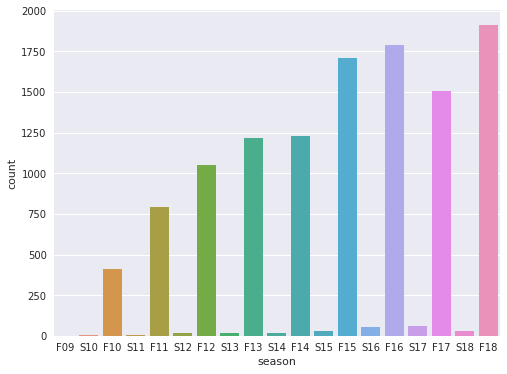

In [38]:
sns.countplot(x='season', data=df, order=season_list)

People often talk about a "GPA inflation" over the years. By plotting the mean GPA for each year (Fall admission only), we see that there is no obvious trend of inflation over the past 10 years.

In [39]:
def plot_by_season(df, col):
    ncol = 'mean_' + col
    aggregated = df.groupby('season').agg({col: {ncol: 'mean'}})
    aggregated.columns = aggregated.columns.droplevel(0)
    sns.barplot(x='season', y=ncol, order=[x for x in season_list if x.startswith('F')], data=aggregated.reset_index())

/home/linghao/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


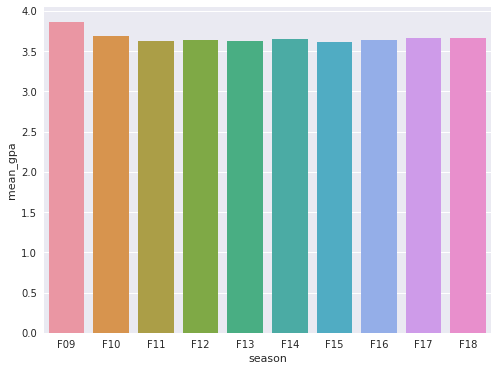

In [40]:
plot_by_season(df, 'gpa')

E-mail and Website seems to be the two dominate methods of notification.

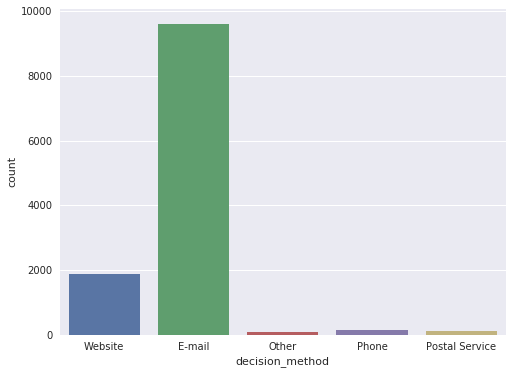

In [41]:
sns.countplot(x='decision_method', data=df)

One important factor in applying graduate school in the U.S. is whether the applicant has educational experience in the U.S., by either being an American student or holding a U.S. degree. Recall the meaning of `status` field in our data:

- `A`: American
- `U`: International with US Degree
- `I`: International
- `O`: Other

We will define a new column to indicate U.S. experience.

In [42]:
df['us_exp'] = ((df.status == 'A') | (df.status == 'U')).astype(int)

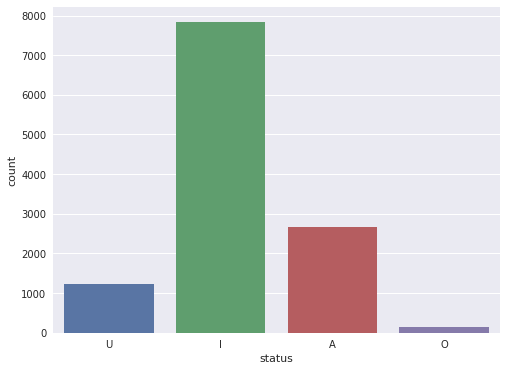

In [43]:
sns.countplot(x='status', data=df)

Now let's make a boxplot for GPA against admission decision. It looks like that admitted students tend to have a higher GPA than those not admitted. But how do we know it's statistically significant?

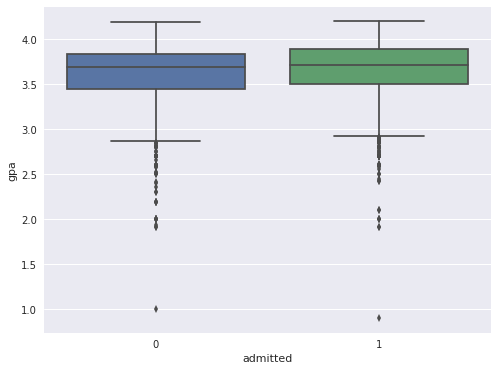

In [44]:
sns.boxplot(x='admitted', y='gpa', data=df)

To do that, we can perform a T-test.

In [45]:
from scipy import stats

def calc_p_value(df, col):
    a = df[df.decision == 'Accepted'][col].values
    b = df[df.decision != 'Accepted'][col].values
    return stats.ttest_ind(a, b).pvalue

In [46]:
calc_p_value(df, 'gpa')

1.5541295290646446e-19

Let's do the same for GRE scores

p-value: 6.393978971332364e-12


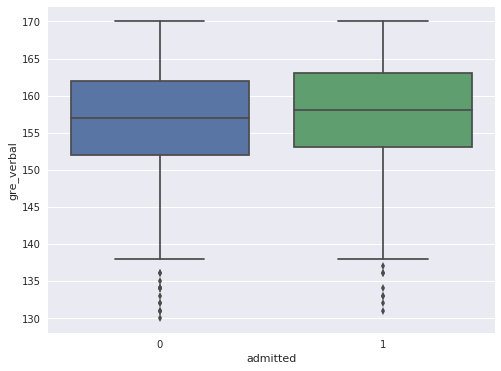

In [47]:
print('p-value: {0}'.format(calc_p_value(df, 'gre_verbal')))
sns.boxplot(x='admitted', y='gre_verbal', data=df)

p-value: 0.15106166840264218


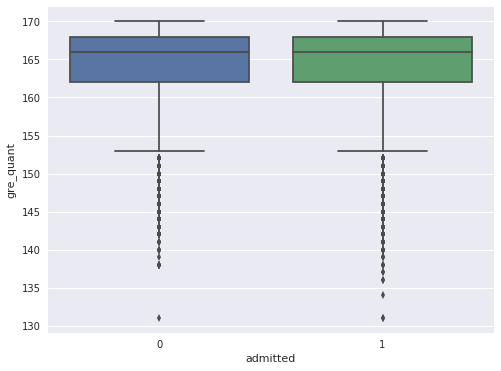

In [48]:
print('p-value: {0}'.format(calc_p_value(df, 'gre_quant')))
sns.boxplot(x='admitted', y='gre_quant', data=df)

p-value: 1.4183486624768823e-06


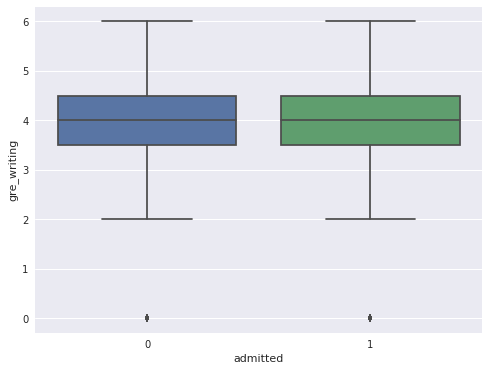

In [49]:
print('p-value: {0}'.format(calc_p_value(df, 'gre_writing')))
sns.boxplot(x='admitted', y='gre_writing', data=df)

It seems like that only GRE quantitative scores are not a significant factor in deciding the outcome of application.

Also, it could be argued that Masters/PhD admissions apply different standards. Let's make the plot and calculate the P-value as well.

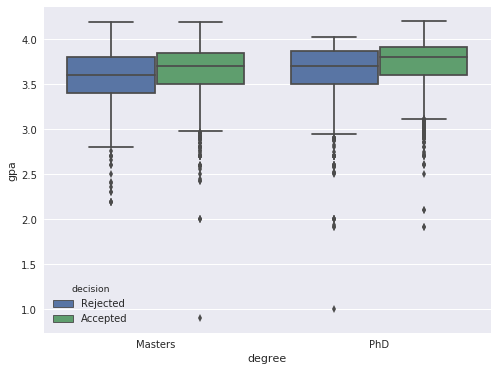

In [50]:
sns.boxplot(x='degree', y='gpa', hue='decision', data=df)

In [51]:
print(calc_p_value(df[df.degree != 'PhD'], 'gpa'))
print(calc_p_value(df[df.degree == 'PhD'], 'gpa'))

2.76355962125e-13
2.76351042116e-12


We see that the overall data seems to suggest both Master and PhD admissions weight GPA as an important factor.

Now let's have some school-specific analysis. These four universities are constantly ranked as tied top 1 in CS:

- Stanford
- CMU
- UCB
- MIT

MIT is pretty unique in that it typically only admits PhD students and the number of admittees is not large. It is therefore excluded in our analysis.

First let's filter out resulst from these schools.

In [52]:
df_stf = df[df.university.str.contains('(?i)stanford')]
df_cmu = df[df.university.str.contains('(?i)carnegie|cmu')]
df_ucb = df[df.university.str.contains('(?i)berkeley|ucb')]

print('# Stanford results = {0}'.format(len(df_stf)))
print('# CMU results = {0}'.format(len(df_cmu)))
print('# UCB results = {0}'.format(len(df_ucb)))

# Stanford results = 416
# CMU results = 712
# UCB results = 328


Let's calculate the P-values for all 3 schools against 4 quantitative scores

In [53]:
def ttest(df, cols):
    for col in cols:
        print('P-value for {0} = {1}'.format(col, calc_p_value(df, col)))

In [54]:
ttest(df_stf, ['gpa', 'gre_verbal', 'gre_quant', 'gre_writing'])

P-value for gpa = 5.330023999432231e-07
P-value for gre_verbal = 0.0009458416887118901
P-value for gre_quant = 0.029073355652110784
P-value for gre_writing = 0.008124472606714709


In [55]:
ttest(df_cmu, ['gpa', 'gre_verbal', 'gre_quant', 'gre_writing'])

P-value for gpa = 0.0004220926912862913
P-value for gre_verbal = 0.0029474170771837
P-value for gre_quant = 0.11838950477234006
P-value for gre_writing = 0.0004598492760462813


In [56]:
ttest(df_ucb, ['gpa', 'gre_verbal', 'gre_quant', 'gre_writing'])

P-value for gpa = 5.880762790093148e-06
P-value for gre_verbal = 0.006228222378515304
P-value for gre_quant = 0.35329405245324974
P-value for gre_writing = 0.014870381434080489


It's interesting to see that, although the overall data suggests no statistical significance for GRE quantitative score, Stanford University seems to value it as well. This is quite expected as Stanford has a extremely high bar resulting from its reputation that goes beyond its prestige in CS.

This phenomenon is also illustrated by the plots below:

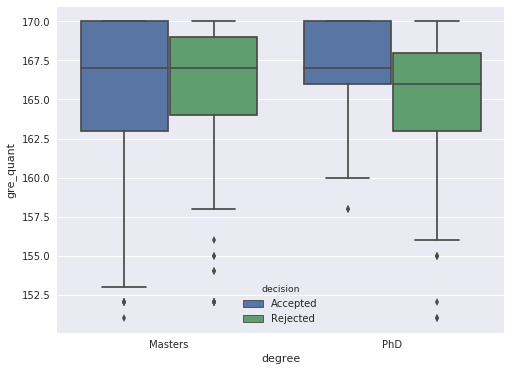

In [57]:
sns.boxplot(x='degree', y='gre_quant', hue='decision', data=df_cmu[df_cmu.gre_quant > 150])

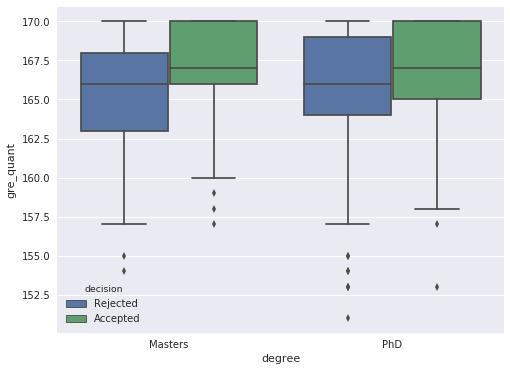

In [58]:
sns.boxplot(x='degree', y='gre_quant', hue='decision', data=df_stf[df_stf.gre_quant > 150])

Finally let's show some plots about the number of Master/PhD applicants and their trends over the years for the 3 schools.

In [59]:
def plot_count_by(df, col):
    aggregated = df.groupby([col, 'decision']).agg({'university': {'count': 'count'}})
    aggregated.columns = aggregated.columns.droplevel(0)
    sns.barplot(x=col, y='count', hue='decision', data=aggregated.reset_index())

/home/linghao/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


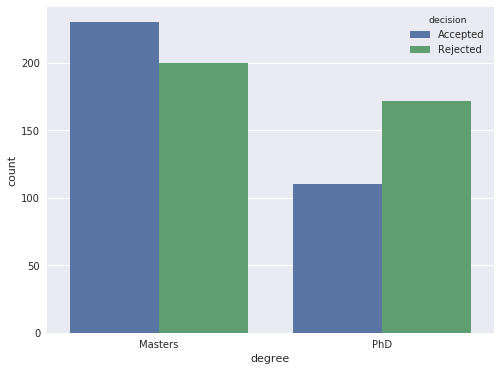

In [60]:
plot_count_by(df_cmu, 'degree')

/home/linghao/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


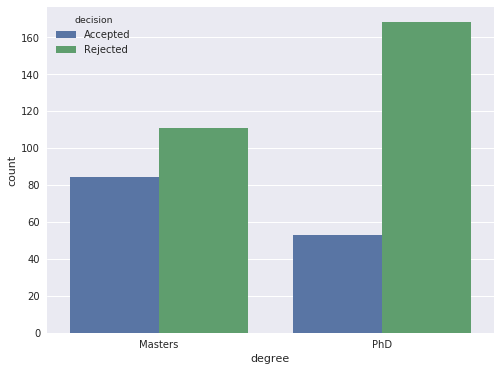

In [61]:
plot_count_by(df_stf, 'degree')

/home/linghao/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


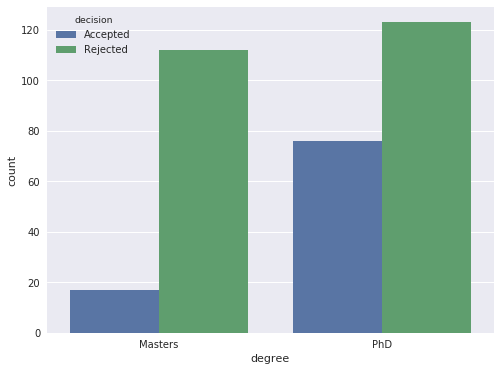

In [62]:
plot_count_by(df_ucb, 'degree')

We can see that Stanford has a relatively low acceptance rate for PhD students. CMU has the highest Master acceptance rate and admittees count (which should not be surprising to us CMU students), while UCB has an outstandingly low acceptance rate for Master students.

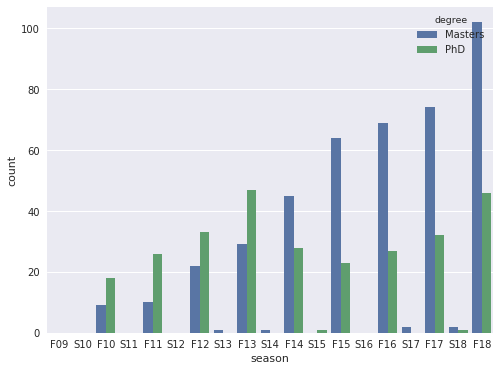

In [63]:
sns.countplot(x='season', hue='degree', data=df_cmu, order=season_list)

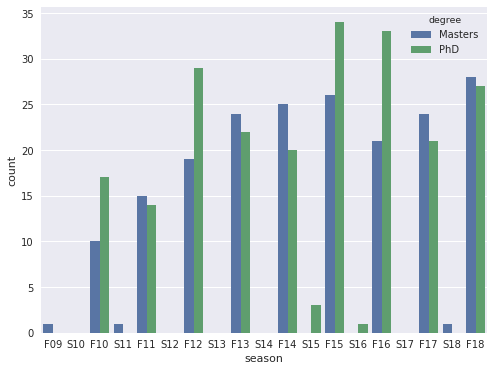

In [64]:
sns.countplot(x='season', hue='degree', data=df_stf, order=season_list)

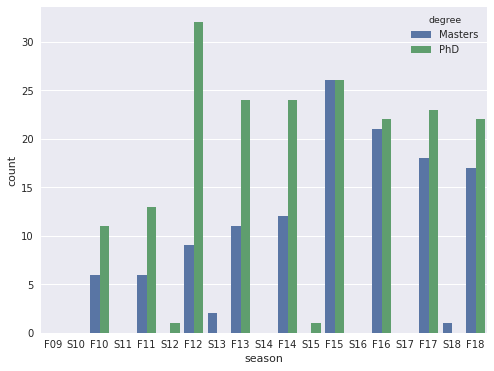

In [65]:
sns.countplot(x='season', hue='degree', data=df_ucb, order=season_list)

We can see that CMU is indeed growing very fast with admissions, especially for Master students. While Stanford and UCB are growing moderately and sometimes even shrinking.

## Modeling

In this section, we will try to build a predictive model. It should be noted that the model will not be very meaningful in terms of actual prediction. Because features from our data are all highly correlated with application success. Training a model is to a large extent fitting the randomness introduced by the admission process (once applicants ourselves, the randomness is totally expected).

Therefore, we will not perform techniques like cross validation or parameter search. This section should be viewed as only supplementary.

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

First, let's prepare the training/testing datasets.

In [67]:
feature_names = ['gpa', 'gre_verbal', 'gre_quant', 'gre_writing', 'us_exp']
X = df[feature_names].values
y = df.admitted.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15688)

We will use a random forest classifier to fit the data and evaluate its performance, as well as to show the feature importances.

In [68]:
clf_rf = RandomForestClassifier(random_state=15688)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=15688, verbose=0,
            warm_start=False)

In [69]:
def evaluate(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    accuracy = sum(y_pred == y_test) / len(y_test)
    print(classification_report(y_test, y_pred))
    print('Accuracy = {0}'.format(accuracy))

In [70]:
evaluate(clf_rf, X_test, y_test)

             precision    recall  f1-score   support

          0       0.55      0.54      0.54      1032
          1       0.65      0.66      0.65      1341

avg / total       0.60      0.60      0.60      2373

Accuracy = 0.6042983565107459


Whereas a majority class predictor will give an accuracy of:

In [71]:
sum(True == y_test) / len(y_test)

0.5651074589127687

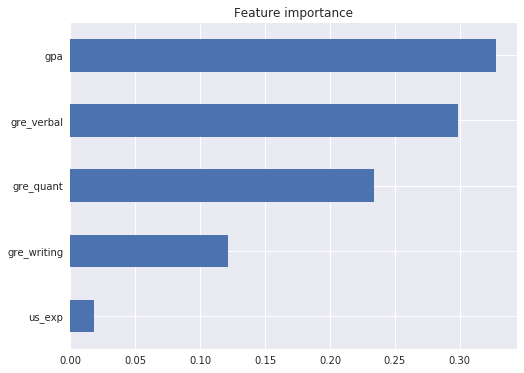

In [72]:
feat_imp = pd.Series(clf_rf.feature_importances_, index=feature_names)
feat_imp.sort_values(inplace=True, ascending=True)
feat_imp.head(20).plot(kind='barh', title='Feature importance')

We see that our simple classifier beats the baseline and that GPA is indeed the most powerful predictor.

We also exprimented with using the comment to predictor the deicion.

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [74]:
df2 = df[~df.comment.isnull()]
X2 = df2.comment
y2 = df2.admitted
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=15688)

In [75]:
clf_text_nb = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
clf_text_nb.fit(X2_train, y2_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [76]:
evaluate(clf_text_nb, X2_test, y2_test)

             precision    recall  f1-score   support

          0       0.86      0.64      0.74       643
          1       0.81      0.94      0.87      1039

avg / total       0.83      0.82      0.82      1682

Accuracy = 0.8240190249702735


The accuracy seems to have improved a lot. The problem is that the comment sometimes directly gives the answer. Therefore, this classifier is not useful.

We can see what are the signal words for accepted/rejected decision using word clouds.

In [77]:
from wordcloud import WordCloud, STOPWORDS

def show_wordcloud(df):
    wc = WordCloud(background_color='white', stopwords=STOPWORDS).generate(str(df[~df.comment.isnull()].comment))
    matplotlib.rcParams['figure.figsize'] = (10, 6)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

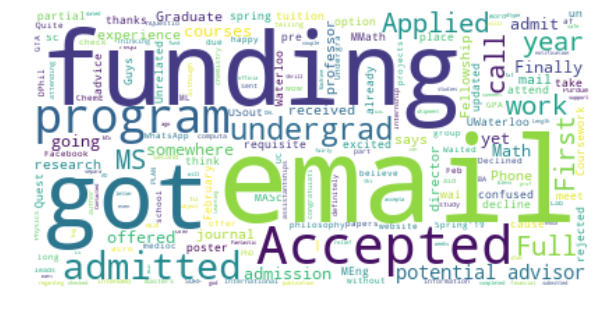

In [78]:
show_wordcloud(df[df['admitted'] == 1])

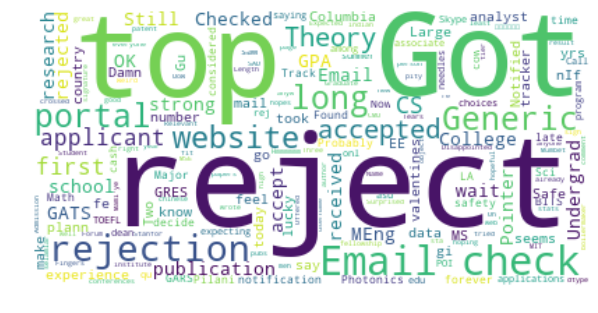

In [79]:
show_wordcloud(df[df['admitted'] == 0])

## Future Work

- Collect more data and extend to subjects other than CS.
- Analyze the differences between programs: CS, HCI, ML, etc.
- Take into account the year of admission, as the bar could change over time.
- Figure out a more automated approach to normalized the `university` field.
- Use dates to analyze admission process timelines for different programs.
- Perform topic modeling (e.g. LDA) on comments.

## References

- [Another work on Scraping and Parsing Grad Cafe Data](https://github.com/deedy/gradcafe_data)
- [Grouping and Aggregating data with Pandas](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/)
- [Better Visualization with Seaborn](https://elitedatascience.com/python-seaborn-tutorial)
- [Use Pipeline to Work with Text Data](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
- [Creating Word Cloud with Python](https://github.com/amueller/word_cloud)